# MLMushroom: Code Challenge-s22
<br>

In [149]:
#imports
import pandas as pd
import numpy as np
from typing import (TypeVar,Optional,Union,Dict,Tuple,List)
from collections.abc import Generator

# type hinting
DataFrame = TypeVar('DataFrame',bound=pd.DataFrame)
Series = TypeVar('Series',bound=pd.Series)
Styler = TypeVar('Styler',bound=object) # pd.io.formats.style.Styler
ndarray = TypeVar('ndarray',bound=np.ndarray)

pd.__version__

'1.4.0'

#### data processing & styling functions

In [2]:
# handler for non-numerical values in each column
def handle_non_numbers(df: DataFrame, inplace: bool=False) -> Union[DataFrame,None]:
    
    # inplace ~ uses reference to actual df, else copy is made
    frame = df
    if not inplace:
        frame = df.copy()
    
    # mapping columns to numerical range based on value set
    for col in frame.columns.values:
        text_2_num = {k:i for i,k in enumerate(set(frame[col].values))}
        frame[col] = list(map(lambda v: text_2_num[v], frame[col]))
        
    return frame if not inplace else None

# coloring for class (poisonous-red/edible-green)
def colored_classes(df: DataFrame) -> Styler:
    return (df.style.applymap(lambda cls: "color:red;" if cls in {"p",1} else "color:green;",
                             subset=pd.IndexSlice[:,"class"]
                             )
           ).export()

In [25]:
#read csv (raw-mushrooms contains text)
raw_mushrooms: DataFrame = pd.read_csv("./mushrooms.csv")
raw_mushrooms.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


<br>**Considerations About the Data**<br>
As seen above, all of the data in each column is *non-numeric*<br>
In order to train a model, the data must be considered in a numerical form.<br><br>
To avoid issues in data processing when doing calculations to determine the training model<br>
and actually training that model when selected, a mapping function is needed to treat each<br>
non-numerical data point as some number.<br><br>

**numerical_mushrooms** will be used from here on out to perform such calculations.<br>
This new DataFrame will contain the resulting data of applying a mapping function<br>
**handle_non_numbers** to the given dataset.<br><br>

In [26]:
# converting text to numbers ~ copy df (numerical-mushrooms)
numerical_mushrooms: DataFrame = handle_non_numbers(raw_mushrooms)
    
# styler for viewing 
colored: Styler = colored_classes(raw_mushrooms)

# viewing poison (red) /edible (green) in color 
(numerical_mushrooms.head(10)
                    .style
                    .use(colored)
)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,5,2,4,0,8,1,1,0,1,1,2,2,2,1,1,0,0,2,4,0,1,6
1,1,5,2,6,0,4,1,1,1,1,1,1,2,2,1,1,0,0,2,4,2,3,0
2,1,4,2,2,0,6,1,1,1,4,1,1,2,2,1,1,0,0,2,4,2,3,1
3,0,5,1,2,0,8,1,1,0,4,1,2,2,2,1,1,0,0,2,4,0,1,6
4,1,5,2,0,1,3,1,0,1,1,0,2,2,2,1,1,0,0,2,1,2,4,0
5,1,5,1,6,0,4,1,1,1,4,1,1,2,2,1,1,0,0,2,4,0,3,0
6,1,4,2,2,0,4,1,1,1,0,1,1,2,2,1,1,0,0,2,4,0,3,1
7,1,4,1,2,0,6,1,1,1,4,1,1,2,2,1,1,0,0,2,4,2,1,1
8,0,5,1,2,0,8,1,1,0,11,1,2,2,2,1,1,0,0,2,4,0,0,0
9,1,4,2,6,0,4,1,1,1,0,1,1,2,2,1,1,0,0,2,4,0,1,1


<br>**Independent vs Dependent Variable**<br><br>
I'm choosing that **class** is the **dependent variable** in this case<br>
since the other attributes determine whether or not the mushroom is edible/poisonous<br><br>
All other attributes in this case are considered **independent variables**<br><br>

<br><br>**Determining a Training Model**<br><br>
In this section I will compare selected independent variables to the dependent variable<br>
(class) to see how it relates numerically, so that a training model can be determined<br><br>
The population size is large ~8000 datapoints and so plotting relationships<br> could be problematic visually. For this reason, I will use a random sample of 20% of the datapoints for each comparison<br><br>

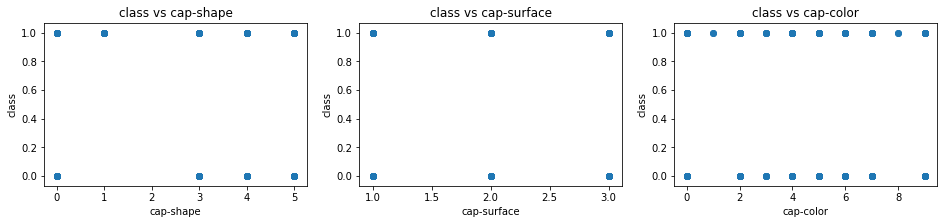

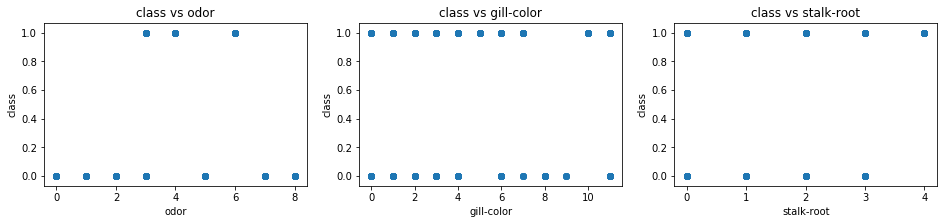

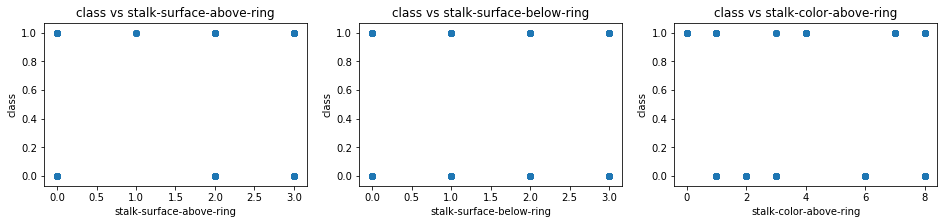

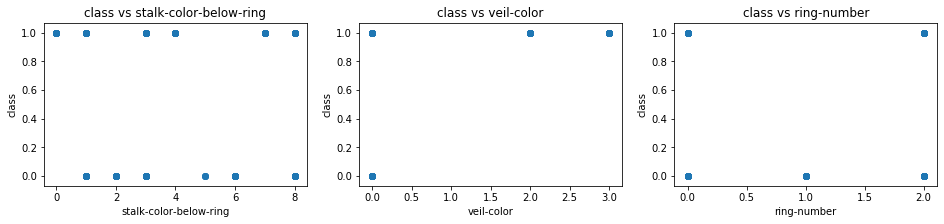

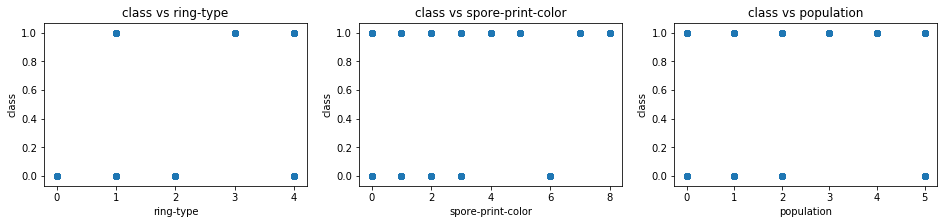

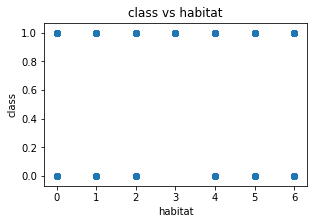

In [148]:
import matplotlib.pyplot as plt

# random sample 20% of rows
sample_rows: DataFrame = numerical_mushrooms.sample(frac=.2)
    
# dependent ~ class selection
dependent: ndarray = sample_rows.loc[:,"class"].to_numpy()
    
# modified definition of itertools 'grouper' function
# see https://docs.python.org/3/library/itertools.html
def tight_grouper(iterable,k) -> Generator:
    """creates k-sized tuple pairs between elements in iterable, if possible. 
       maximizes k-size groupings if iterable size is indivisible by k evenly 
       and is of atleast k-length. If indivisible, last grouping will be of size
       less than k.
    """
    from itertools import zip_longest
    args = [iter(iterable)] * k
    for g in zip_longest(*args,fillvalue=False):
        while not all(g := list(g)): g.pop()
        yield tuple(g)
    
def nrow_scatter(features: DataFrame, N: int=2) -> None:
    """creates N scatter plots against 'class' dependent variable for all features.
       ideally, N plots will be equally partitioned per row, if capable.
       if not, then the last row will have fewer plots than the rest.
    """
    
    plt.rcParams["figure.figsize"] = [16.00,3.00]
    it = tight_grouper(features,N)
    while True:
        try:
            if len(pair := next(it)) == 1:
                fig,ax = plt.subplots(1,N)
                ax[0].set_title(f"class vs {pair[0]}")
                ax[0].set_xlabel(pair[0])
                ax[0].set_ylabel("class")
                ax[0].scatter(sample_rows.loc[:,pair[0]].to_numpy(),dependent)
                for ax in ax[1:]:
                    fig.delaxes(ax)
            else:
                _,axs = plt.subplots(1,len(pair))
                for ax,pname in zip(axs,pair):
                    ax.set_title(f"class vs {pname}")
                    ax.set_xlabel(pname)
                    ax.set_ylabel("class")
                    ax.scatter(sample_rows.loc[:,pname].to_numpy(),dependent)
            
            plt.show()
            
        except StopIteration:
            break


# plot 'class' vs all independent variables 1 by 1, 3 per row
nrow_scatter(numerical_mushrooms.columns.values[1:],N=3)

<br>**Cleaning**<br><br>
A few of the features in the above plot seem to have a similar<br>
outlier-type pattern to them. Namely, the stalk-shape, gill-size, gill-spacing,<br>
gill-attachment, veil-type, and bruises columns. The rest of the graphs appear to be similar.<br><br>

I will drop the affected columns from the data frame and recap the general trend / model selection<br><br>

In [92]:
# dropping stalk-shape, gill-size, gill-spacing, gill-attachment, veil-type, and bruises
numerical_mushrooms.drop(columns=["stalk-shape",
                                  "gill-size",
                                  "gill-spacing",
                                  "gill-attachment",
                                  "veil-type",
                                  "bruises"],
                         axis=1,
                         inplace=True)

# viewing poison (red) /edible (green) in color 
(numerical_mushrooms.head(10)
                    .style
                    .use(colored)
)

,class,cap-shape,cap-surface,cap-color,odor,gill-color,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,5,2,4,8,1,2,2,2,1,1,0,2,4,0,1,6
1,1,5,2,6,4,1,1,2,2,1,1,0,2,4,2,3,0
2,1,4,2,2,6,4,1,2,2,1,1,0,2,4,2,3,1
3,0,5,1,2,8,4,2,2,2,1,1,0,2,4,0,1,6
4,1,5,2,0,3,1,2,2,2,1,1,0,2,1,2,4,0
5,1,5,1,6,4,4,1,2,2,1,1,0,2,4,0,3,0
6,1,4,2,2,4,0,1,2,2,1,1,0,2,4,0,3,1
7,1,4,1,2,6,4,1,2,2,1,1,0,2,4,2,1,1
8,0,5,1,2,8,11,2,2,2,1,1,0,2,4,0,0,0
9,1,4,2,6,4,0,1,2,2,1,1,0,2,4,0,1,1


<br>**Recap**<br><br>
The plots seem to fit a logistic function generally.<br>
This assignment is about classificiation and the predicted value<br>
will be a category of whether a mushroom is edible or poisonous.<br><br>
For these reasons, linear regression doesn't make sense as a model here<br>
since the predicted value is not continuous; however, as the look of these<br>
plots contend, a **logistic regression** model might fit more<br>

I will split training & testing data using **80-20** ruling;<br>
80% of the data will be used to train, 20% will go to testing.<br>

<br>**Train Model**<br><br>

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# independent variables (all except 'class')
X: ndarray = numerical_mushrooms.drop("class",axis=1).to_numpy()

# dependent variables ('class')
y: ndarray = numerical_mushrooms["class"].to_numpy()
    
# train-test-split:: 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

# make logistic regression model & train
model = LogisticRegression(solver="lbfgs",max_iter=1000)
model.fit(X_train,y_train)

# get predictions for the test sample using labels not including 'class'
predictions = model.predict(X_test)

<br>**Analyzing Model**<br><br>

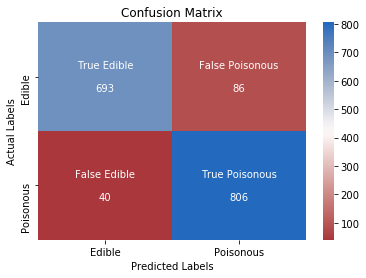


Accuracy Score
92.25%


In [97]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sn

# create confusion matrix
cfmat: ndarray = confusion_matrix(y_test,predictions)
    
# plot confusion matrix
plt.rcParams["figure.figsize"] = [6.00,4.00]
counts = [f"{v}" for v in cfmat.flatten()]
names = ["True Edible","False Poisonous","False Edible","True Poisonous"]
labels = np.asarray([f"{n}\n\n{c}" for c,n in zip(counts,names)]).reshape(2,2)
ax = sn.heatmap(cfmat,
                fmt='',
                annot=labels, 
                cmap="vlag_r")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.xaxis.set_ticklabels(["Edible","Poisonous"])
ax.yaxis.set_ticklabels(["Edible","Poisonous"])
plt.show()


print("\nAccuracy Score")
print(f"{accuracy_score(y_test,predictions)*100:.2f}%")

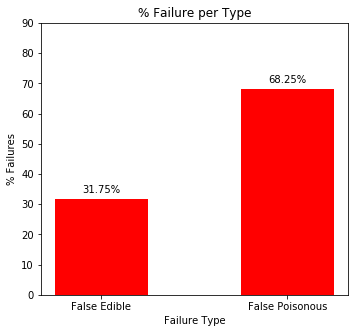

In [142]:
# plotting failures
plt.rcParams["figure.figsize"] = [5.50,5.00]
x = ["False Edible", "False Poisonous"]
y = [(40/126)*100,(86/126)*100]
fig, ax = plt.subplots()
plots = ax.bar(x,y,.5,align='center',color='r')
for plot in plots:
    height=plot.get_height()
    ax.text(x=plot.get_x()+plot.get_width()/2,
            y=height+2,
            s=f"{height:.2f}%",
            ha="center"
           )
plt.title("% Failure per Type")
plt.ylabel("% Failures")
plt.xlabel("Failure Type")
plt.ylim(bottom=0,top=90)
plt.show()

<br><br>**Verifying Model**<br><br>
Now that the model is created, to ensure the accuracy is correct we will re-train model<br>
this time using a different state and using the .score method to calculate accurracy<br>
this will be compared and averaged against above confusion matrix<br><br>

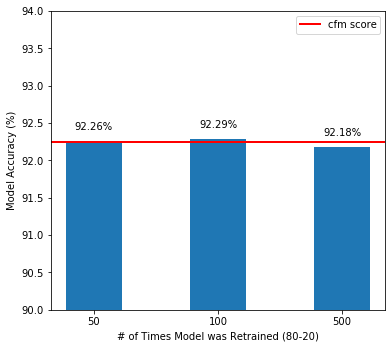

In [107]:
def large_trials(n: int=1) -> List[float]:
    """Retrain logistic regression model using 80-20 split, 80% train / 20% test.
       Do this n times, each time keeping track of the accuracy score. 
       
       params:
               n: int - number of trials (times the model will be retrained at 80-20), default 1.
               
       return: list of floats representing accuracy scores for n trials as %
    """
    X: ndarray = numerical_mushrooms.drop("class",axis=1).to_numpy()
    y: ndarray = numerical_mushrooms["class"].to_numpy()
    model = LogisticRegression(solver="lbfgs",max_iter=1000)
    scores: List[float] = []
            
    for _ in range(n):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)
        model.fit(X_train,y_train)
        scores.append(model.score(X_test,y_test)*100)
    
    return scores

def avg(scores: List[float]) -> float:
    return round(sum(scores)/len(scores),2)


# do 50,100,500 trials
s50 = large_trials(n=50)
s100 = large_trials(n=100)
s500 = large_trials(n=500)
averages = list(map(avg,[s50,s100,s500]))


# plot the averages in bar chart
x = ["50","100","500"]
y = [*averages]

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [6.00,5.50]
plots = ax.bar(x,y,.45,align='center')
for plot in plots:
    height=plot.get_height()
    ax.text(x=plot.get_x()+plot.get_width()/2,
            y=height+.15,
            s=f"{height:.2f}%",
            ha="center"
           )
plt.ylabel("Model Accuracy (%)")
plt.xlabel("# of Times Model was Retrained (80-20)")
plt.ylim(bottom=90,top=94)
plt.axhline(y=92.25,linewidth=2,label='cfm score',color='red')
plt.legend(loc='upper right')
plt.show()

<br><br><br>
### Conclusion
<br><br>
In order to perform an analysis on the given dataset, a numerical mapping was used<br>
associating each symbol per column with a specific identifier<br><br>

With this numerical data, an independent variable - 'class' - and a set of dependent variables<br>
were identified. Through visualization, outlier features were left out in order to identify<br>
a more representative model.<br><br>

The model chosen was **logistic regression**. When trained a single time on 80% of the dataset,<br>
a confusion matrix and accuracy score showed that the model guessed correctly about 92% of the time.<br>
When re-trained through 50, 100, and 500 consecutive trials on 80% of the dataset each time, the score<br>
remained about the same. That is to say, generally, the model correctly predicted whether or not a mushroom<br>
was edible or poisonous about **92% of time**.<br><br>

According to the confusion matrix for the first time the model was trained, there was about a 92% success rate, followed<br>
by an 8% failure rate, split across two cases:<br>

    1. the model predicting a mushroom as poisonous when it was actually edible
    2. the model predicting a mushroom as edible when it was actually poisonous
<br>
Of those failures, roughly 68% were attributed to the lesser case of a mushroom being predicted as<br>
poisonous when it was actually edible. About 32% of the failures were attributed to the worst case scenario<br>
of a mushroom being predicted as edible when it was actually poisonous, unfortunately.<br><br>
    
